# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import time

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.GELU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 2)

# Loss Funktion; gibt Fehler an
loss_fn_MSE = nn.MSELoss()
loss_fn_L1 = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn_MSE(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn_L1(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Runtime measurement
train_time_start = time.process_time()
#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn_MSE(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

train_time = time.process_time() - train_time_start
print('Training time:',train_time, 's')

Epoch 1/200, Iteration 1/12, Loss: 0.9713
Epoch 1/200, Iteration 2/12, Loss: 0.4947
Epoch 1/200, Iteration 3/12, Loss: 0.4270
Epoch 1/200, Iteration 4/12, Loss: 0.1638
Epoch 1/200, Iteration 5/12, Loss: 0.1053
Epoch 1/200, Iteration 6/12, Loss: 0.1803
Epoch 1/200, Iteration 7/12, Loss: 0.2686
Epoch 1/200, Iteration 8/12, Loss: 0.2988
Epoch 1/200, Iteration 9/12, Loss: 0.3273
Epoch 1/200, Iteration 10/12, Loss: 0.1382
Epoch 1/200, Iteration 11/12, Loss: 0.0981
Epoch 1/200, Iteration 12/12, Loss: 0.0953
Epoch 1/200, Iteration 13/12, Loss: 0.0302
Train Error: 
 Accuracy: 70.88%, Avg loss: 0.061454, MRE: 0.155576, MAE: 0.023960 

Test Error: 
 Accuracy: 78.0%, Avg loss: 0.047431, MRE: 0.130433, MAE: 0.021441 

Epoch 2/200, Iteration 1/12, Loss: 0.0483
Epoch 2/200, Iteration 2/12, Loss: 0.0490
Epoch 2/200, Iteration 3/12, Loss: 0.0900
Epoch 2/200, Iteration 4/12, Loss: 0.0814
Epoch 2/200, Iteration 5/12, Loss: 0.1026
Epoch 2/200, Iteration 6/12, Loss: 0.0950
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 92.38%, Avg loss: 0.013277, MRE: 0.050487, MAE: 0.008053 

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.014844, MRE: 0.043258, MAE: 0.008664 

Epoch 13/200, Iteration 1/12, Loss: 0.0136
Epoch 13/200, Iteration 2/12, Loss: 0.0094
Epoch 13/200, Iteration 3/12, Loss: 0.0232
Epoch 13/200, Iteration 4/12, Loss: 0.0119
Epoch 13/200, Iteration 5/12, Loss: 0.0098
Epoch 13/200, Iteration 6/12, Loss: 0.0276
Epoch 13/200, Iteration 7/12, Loss: 0.0097
Epoch 13/200, Iteration 8/12, Loss: 0.0274
Epoch 13/200, Iteration 9/12, Loss: 0.0114
Epoch 13/200, Iteration 10/12, Loss: 0.0195
Epoch 13/200, Iteration 11/12, Loss: 0.0186
Epoch 13/200, Iteration 12/12, Loss: 0.0136
Epoch 13/200, Iteration 13/12, Loss: 0.0072
Train Error: 
 Accuracy: 84.12%, Avg loss: 0.010287, MRE: 0.046490, MAE: 0.007158 

Test Error: 
 Accuracy: 81.0%, Avg loss: 0.009923, MRE: 0.040846, MAE: 0.007360 

Epoch 14/200, Iteration 1/12, Loss: 0.0054
Epoch 14/200, Iteration 2/12, Loss: 0.0260
Epoch 14/200, Itera

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.005496, MRE: 0.038567, MAE: 0.005283 

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.003542, MRE: 0.024868, MAE: 0.004582 

Epoch 25/200, Iteration 1/12, Loss: 0.0064
Epoch 25/200, Iteration 2/12, Loss: 0.0022
Epoch 25/200, Iteration 3/12, Loss: 0.0134
Epoch 25/200, Iteration 4/12, Loss: 0.0029
Epoch 25/200, Iteration 5/12, Loss: 0.0087
Epoch 25/200, Iteration 6/12, Loss: 0.0027
Epoch 25/200, Iteration 7/12, Loss: 0.0048
Epoch 25/200, Iteration 8/12, Loss: 0.0026
Epoch 25/200, Iteration 9/12, Loss: 0.0047
Epoch 25/200, Iteration 10/12, Loss: 0.0080
Epoch 25/200, Iteration 11/12, Loss: 0.0066
Epoch 25/200, Iteration 12/12, Loss: 0.0067
Epoch 25/200, Iteration 13/12, Loss: 0.0040
Train Error: 
 Accuracy: 97.12%, Avg loss: 0.004648, MRE: 0.044262, MAE: 0.004595 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.002974, MRE: 0.021666, MAE: 0.003941 

Epoch 26/200, Iteration 1/12, Loss: 0.0039
Epoch 26/200, Iteration 2/12, Loss: 0.0045
Epoch 26/200, Itera

Train Error: 
 Accuracy: 98.62%, Avg loss: 0.003953, MRE: 0.035846, MAE: 0.004416 

Test Error: 
 Accuracy: 98.5%, Avg loss: 0.003529, MRE: 0.022173, MAE: 0.004171 

Epoch 37/200, Iteration 1/12, Loss: 0.0024
Epoch 37/200, Iteration 2/12, Loss: 0.0031
Epoch 37/200, Iteration 3/12, Loss: 0.0037
Epoch 37/200, Iteration 4/12, Loss: 0.0019
Epoch 37/200, Iteration 5/12, Loss: 0.0034
Epoch 37/200, Iteration 6/12, Loss: 0.0017
Epoch 37/200, Iteration 7/12, Loss: 0.0059
Epoch 37/200, Iteration 8/12, Loss: 0.0029
Epoch 37/200, Iteration 9/12, Loss: 0.0036
Epoch 37/200, Iteration 10/12, Loss: 0.0065
Epoch 37/200, Iteration 11/12, Loss: 0.0028
Epoch 37/200, Iteration 12/12, Loss: 0.0053
Epoch 37/200, Iteration 13/12, Loss: 0.0122
Train Error: 
 Accuracy: 83.75%, Avg loss: 0.006264, MRE: 0.036900, MAE: 0.005155 

Test Error: 
 Accuracy: 82.0%, Avg loss: 0.003578, MRE: 0.025225, MAE: 0.004691 

Epoch 38/200, Iteration 1/12, Loss: 0.0035
Epoch 38/200, Iteration 2/12, Loss: 0.0137
Epoch 38/200, Itera

Train Error: 
 Accuracy: 96.38%, Avg loss: 0.004316, MRE: 0.048903, MAE: 0.005416 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.004132, MRE: 0.037458, MAE: 0.005967 

Epoch 49/200, Iteration 1/12, Loss: 0.0033
Epoch 49/200, Iteration 2/12, Loss: 0.0029
Epoch 49/200, Iteration 3/12, Loss: 0.0067
Epoch 49/200, Iteration 4/12, Loss: 0.0027
Epoch 49/200, Iteration 5/12, Loss: 0.0051
Epoch 49/200, Iteration 6/12, Loss: 0.0054
Epoch 49/200, Iteration 7/12, Loss: 0.0024
Epoch 49/200, Iteration 8/12, Loss: 0.0032
Epoch 49/200, Iteration 9/12, Loss: 0.0043
Epoch 49/200, Iteration 10/12, Loss: 0.0019
Epoch 49/200, Iteration 11/12, Loss: 0.0026
Epoch 49/200, Iteration 12/12, Loss: 0.0049
Epoch 49/200, Iteration 13/12, Loss: 0.0064
Train Error: 
 Accuracy: 98.0%, Avg loss: 0.003277, MRE: 0.035193, MAE: 0.004197 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001590, MRE: 0.020350, MAE: 0.003461 

Epoch 50/200, Iteration 1/12, Loss: 0.0042
Epoch 50/200, Iteration 2/12, Loss: 0.0144
Epoch 50/200, Itera

Train Error: 
 Accuracy: 96.75%, Avg loss: 0.002713, MRE: 0.031634, MAE: 0.004111 

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.002183, MRE: 0.022830, MAE: 0.004272 

Epoch 61/200, Iteration 1/12, Loss: 0.0021
Epoch 61/200, Iteration 2/12, Loss: 0.0019
Epoch 61/200, Iteration 3/12, Loss: 0.0037
Epoch 61/200, Iteration 4/12, Loss: 0.0016
Epoch 61/200, Iteration 5/12, Loss: 0.0037
Epoch 61/200, Iteration 6/12, Loss: 0.0025
Epoch 61/200, Iteration 7/12, Loss: 0.0074
Epoch 61/200, Iteration 8/12, Loss: 0.0018
Epoch 61/200, Iteration 9/12, Loss: 0.0026
Epoch 61/200, Iteration 10/12, Loss: 0.0019
Epoch 61/200, Iteration 11/12, Loss: 0.0008
Epoch 61/200, Iteration 12/12, Loss: 0.0031
Epoch 61/200, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.002236, MRE: 0.027387, MAE: 0.003379 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001650, MRE: 0.018510, MAE: 0.003256 

Epoch 62/200, Iteration 1/12, Loss: 0.0014
Epoch 62/200, Iteration 2/12, Loss: 0.0016
Epoch 62/200, Itera

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.002021, MRE: 0.025198, MAE: 0.003043 

Test Error: 
 Accuracy: 97.0%, Avg loss: 0.001379, MRE: 0.016993, MAE: 0.003027 

Epoch 73/200, Iteration 1/12, Loss: 0.0034
Epoch 73/200, Iteration 2/12, Loss: 0.0010
Epoch 73/200, Iteration 3/12, Loss: 0.0018
Epoch 73/200, Iteration 4/12, Loss: 0.0008
Epoch 73/200, Iteration 5/12, Loss: 0.0010
Epoch 73/200, Iteration 6/12, Loss: 0.0012
Epoch 73/200, Iteration 7/12, Loss: 0.0022
Epoch 73/200, Iteration 8/12, Loss: 0.0014
Epoch 73/200, Iteration 9/12, Loss: 0.0027
Epoch 73/200, Iteration 10/12, Loss: 0.0021
Epoch 73/200, Iteration 11/12, Loss: 0.0032
Epoch 73/200, Iteration 12/12, Loss: 0.0036
Epoch 73/200, Iteration 13/12, Loss: 0.0009
Train Error: 
 Accuracy: 98.75%, Avg loss: 0.001994, MRE: 0.027032, MAE: 0.003003 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001785, MRE: 0.018650, MAE: 0.003069 

Epoch 74/200, Iteration 1/12, Loss: 0.0045
Epoch 74/200, Iteration 2/12, Loss: 0.0018
Epoch 74/200, Itera

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001940, MRE: 0.025595, MAE: 0.003195 

Test Error: 
 Accuracy: 99.0%, Avg loss: 0.001642, MRE: 0.018758, MAE: 0.003193 

Epoch 85/200, Iteration 1/12, Loss: 0.0024
Epoch 85/200, Iteration 2/12, Loss: 0.0025
Epoch 85/200, Iteration 3/12, Loss: 0.0022
Epoch 85/200, Iteration 4/12, Loss: 0.0019
Epoch 85/200, Iteration 5/12, Loss: 0.0016
Epoch 85/200, Iteration 6/12, Loss: 0.0016
Epoch 85/200, Iteration 7/12, Loss: 0.0011
Epoch 85/200, Iteration 8/12, Loss: 0.0017
Epoch 85/200, Iteration 9/12, Loss: 0.0030
Epoch 85/200, Iteration 10/12, Loss: 0.0025
Epoch 85/200, Iteration 11/12, Loss: 0.0023
Epoch 85/200, Iteration 12/12, Loss: 0.0031
Epoch 85/200, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 98.88%, Avg loss: 0.002290, MRE: 0.033005, MAE: 0.003566 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.001741, MRE: 0.021963, MAE: 0.003366 

Epoch 86/200, Iteration 1/12, Loss: 0.0015
Epoch 86/200, Iteration 2/12, Loss: 0.0029
Epoch 86/200, Itera

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001638, MRE: 0.023748, MAE: 0.003479 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.001141, MRE: 0.017061, MAE: 0.003361 

Epoch 97/200, Iteration 1/12, Loss: 0.0012
Epoch 97/200, Iteration 2/12, Loss: 0.0019
Epoch 97/200, Iteration 3/12, Loss: 0.0013
Epoch 97/200, Iteration 4/12, Loss: 0.0050
Epoch 97/200, Iteration 5/12, Loss: 0.0040
Epoch 97/200, Iteration 6/12, Loss: 0.0019
Epoch 97/200, Iteration 7/12, Loss: 0.0023
Epoch 97/200, Iteration 8/12, Loss: 0.0026
Epoch 97/200, Iteration 9/12, Loss: 0.0028
Epoch 97/200, Iteration 10/12, Loss: 0.0042
Epoch 97/200, Iteration 11/12, Loss: 0.0044
Epoch 97/200, Iteration 12/12, Loss: 0.0027
Epoch 97/200, Iteration 13/12, Loss: 0.0038
Train Error: 
 Accuracy: 90.88%, Avg loss: 0.003407, MRE: 0.035920, MAE: 0.004414 

Test Error: 
 Accuracy: 91.0%, Avg loss: 0.003373, MRE: 0.030062, MAE: 0.004619 

Epoch 98/200, Iteration 1/12, Loss: 0.0024
Epoch 98/200, Iteration 2/12, Loss: 0.0021
Epoch 98/200, Iter

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.001015, MRE: 0.017304, MAE: 0.002032 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000695, MRE: 0.010742, MAE: 0.001936 

Epoch 109/200, Iteration 1/12, Loss: 0.0007
Epoch 109/200, Iteration 2/12, Loss: 0.0006
Epoch 109/200, Iteration 3/12, Loss: 0.0008
Epoch 109/200, Iteration 4/12, Loss: 0.0007
Epoch 109/200, Iteration 5/12, Loss: 0.0009
Epoch 109/200, Iteration 6/12, Loss: 0.0017
Epoch 109/200, Iteration 7/12, Loss: 0.0014
Epoch 109/200, Iteration 8/12, Loss: 0.0008
Epoch 109/200, Iteration 9/12, Loss: 0.0027
Epoch 109/200, Iteration 10/12, Loss: 0.0006
Epoch 109/200, Iteration 11/12, Loss: 0.0010
Epoch 109/200, Iteration 12/12, Loss: 0.0008
Epoch 109/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.001020, MRE: 0.019972, MAE: 0.002062 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.000737, MRE: 0.012715, MAE: 0.002011 

Epoch 110/200, Iteration 1/12, Loss: 0.0015
Epoch 110/200, Iteration 2/12, Loss: 0.0005
Epo

Train Error: 
 Accuracy: 98.88%, Avg loss: 0.000955, MRE: 0.017211, MAE: 0.001958 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000699, MRE: 0.010808, MAE: 0.001915 

Epoch 121/200, Iteration 1/12, Loss: 0.0005
Epoch 121/200, Iteration 2/12, Loss: 0.0006
Epoch 121/200, Iteration 3/12, Loss: 0.0003
Epoch 121/200, Iteration 4/12, Loss: 0.0004
Epoch 121/200, Iteration 5/12, Loss: 0.0027
Epoch 121/200, Iteration 6/12, Loss: 0.0014
Epoch 121/200, Iteration 7/12, Loss: 0.0018
Epoch 121/200, Iteration 8/12, Loss: 0.0003
Epoch 121/200, Iteration 9/12, Loss: 0.0013
Epoch 121/200, Iteration 10/12, Loss: 0.0007
Epoch 121/200, Iteration 11/12, Loss: 0.0008
Epoch 121/200, Iteration 12/12, Loss: 0.0012
Epoch 121/200, Iteration 13/12, Loss: 0.0004
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000962, MRE: 0.017473, MAE: 0.001991 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000733, MRE: 0.011076, MAE: 0.001990 

Epoch 122/200, Iteration 1/12, Loss: 0.0004
Epoch 122/200, Iteration 2/12, Loss: 0.0014
Epoch

Epoch 132/200, Iteration 13/12, Loss: 0.0003
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000942, MRE: 0.017218, MAE: 0.001957 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000699, MRE: 0.011013, MAE: 0.001946 

Epoch 133/200, Iteration 1/12, Loss: 0.0014
Epoch 133/200, Iteration 2/12, Loss: 0.0007
Epoch 133/200, Iteration 3/12, Loss: 0.0008
Epoch 133/200, Iteration 4/12, Loss: 0.0005
Epoch 133/200, Iteration 5/12, Loss: 0.0006
Epoch 133/200, Iteration 6/12, Loss: 0.0006
Epoch 133/200, Iteration 7/12, Loss: 0.0011
Epoch 133/200, Iteration 8/12, Loss: 0.0016
Epoch 133/200, Iteration 9/12, Loss: 0.0015
Epoch 133/200, Iteration 10/12, Loss: 0.0007
Epoch 133/200, Iteration 11/12, Loss: 0.0006
Epoch 133/200, Iteration 12/12, Loss: 0.0008
Epoch 133/200, Iteration 13/12, Loss: 0.0028
Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000940, MRE: 0.017658, MAE: 0.001961 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000686, MRE: 0.011297, MAE: 0.001930 

Epoch 134/200, Iteration 1/12, Loss: 0.0015
Epo

Train Error: 
 Accuracy: 99.12%, Avg loss: 0.000926, MRE: 0.016805, MAE: 0.001920 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000656, MRE: 0.010705, MAE: 0.001886 

Epoch 144/200, Iteration 1/12, Loss: 0.0018
Epoch 144/200, Iteration 2/12, Loss: 0.0013
Epoch 144/200, Iteration 3/12, Loss: 0.0003
Epoch 144/200, Iteration 4/12, Loss: 0.0013
Epoch 144/200, Iteration 5/12, Loss: 0.0005
Epoch 144/200, Iteration 6/12, Loss: 0.0007
Epoch 144/200, Iteration 7/12, Loss: 0.0015
Epoch 144/200, Iteration 8/12, Loss: 0.0005
Epoch 144/200, Iteration 9/12, Loss: 0.0004
Epoch 144/200, Iteration 10/12, Loss: 0.0005
Epoch 144/200, Iteration 11/12, Loss: 0.0020
Epoch 144/200, Iteration 12/12, Loss: 0.0004
Epoch 144/200, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.0%, Avg loss: 0.000915, MRE: 0.022176, MAE: 0.001911 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000658, MRE: 0.010554, MAE: 0.001885 

Epoch 145/200, Iteration 1/12, Loss: 0.0021
Epoch 145/200, Iteration 2/12, Loss: 0.0005
Epoch

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000904, MRE: 0.016588, MAE: 0.001898 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000663, MRE: 0.010588, MAE: 0.001891 

Epoch 156/200, Iteration 1/12, Loss: 0.0009
Epoch 156/200, Iteration 2/12, Loss: 0.0007
Epoch 156/200, Iteration 3/12, Loss: 0.0004
Epoch 156/200, Iteration 4/12, Loss: 0.0006
Epoch 156/200, Iteration 5/12, Loss: 0.0006
Epoch 156/200, Iteration 6/12, Loss: 0.0004
Epoch 156/200, Iteration 7/12, Loss: 0.0013
Epoch 156/200, Iteration 8/12, Loss: 0.0005
Epoch 156/200, Iteration 9/12, Loss: 0.0015
Epoch 156/200, Iteration 10/12, Loss: 0.0004
Epoch 156/200, Iteration 11/12, Loss: 0.0015
Epoch 156/200, Iteration 12/12, Loss: 0.0022
Epoch 156/200, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000898, MRE: 0.016649, MAE: 0.001896 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000670, MRE: 0.010544, MAE: 0.001889 

Epoch 157/200, Iteration 1/12, Loss: 0.0003
Epoch 157/200, Iteration 2/12, Loss: 0.0009
Epoc

Epoch 167/200, Iteration 10/12, Loss: 0.0006
Epoch 167/200, Iteration 11/12, Loss: 0.0016
Epoch 167/200, Iteration 12/12, Loss: 0.0017
Epoch 167/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000894, MRE: 0.016532, MAE: 0.001894 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000664, MRE: 0.010562, MAE: 0.001888 

Epoch 168/200, Iteration 1/12, Loss: 0.0014
Epoch 168/200, Iteration 2/12, Loss: 0.0009
Epoch 168/200, Iteration 3/12, Loss: 0.0006
Epoch 168/200, Iteration 4/12, Loss: 0.0009
Epoch 168/200, Iteration 5/12, Loss: 0.0007
Epoch 168/200, Iteration 6/12, Loss: 0.0010
Epoch 168/200, Iteration 7/12, Loss: 0.0005
Epoch 168/200, Iteration 8/12, Loss: 0.0003
Epoch 168/200, Iteration 9/12, Loss: 0.0011
Epoch 168/200, Iteration 10/12, Loss: 0.0015
Epoch 168/200, Iteration 11/12, Loss: 0.0007
Epoch 168/200, Iteration 12/12, Loss: 0.0015
Epoch 168/200, Iteration 13/12, Loss: 0.0008
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000895, MRE: 0.016495, MAE: 0.001

Epoch 178/200, Iteration 13/12, Loss: 0.0007
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000887, MRE: 0.016502, MAE: 0.001880 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000664, MRE: 0.010565, MAE: 0.001889 

Epoch 179/200, Iteration 1/12, Loss: 0.0013
Epoch 179/200, Iteration 2/12, Loss: 0.0011
Epoch 179/200, Iteration 3/12, Loss: 0.0003
Epoch 179/200, Iteration 4/12, Loss: 0.0005
Epoch 179/200, Iteration 5/12, Loss: 0.0005
Epoch 179/200, Iteration 6/12, Loss: 0.0004
Epoch 179/200, Iteration 7/12, Loss: 0.0012
Epoch 179/200, Iteration 8/12, Loss: 0.0004
Epoch 179/200, Iteration 9/12, Loss: 0.0018
Epoch 179/200, Iteration 10/12, Loss: 0.0015
Epoch 179/200, Iteration 11/12, Loss: 0.0015
Epoch 179/200, Iteration 12/12, Loss: 0.0005
Epoch 179/200, Iteration 13/12, Loss: 0.0005
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000976, MRE: 0.016552, MAE: 0.001910 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000664, MRE: 0.010566, MAE: 0.001889 

Epoch 180/200, Iteration 1/12, Loss: 0.0007
Epo

Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000891, MRE: 0.016451, MAE: 0.001885 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000664, MRE: 0.010566, MAE: 0.001889 

Epoch 190/200, Iteration 1/12, Loss: 0.0017
Epoch 190/200, Iteration 2/12, Loss: 0.0013
Epoch 190/200, Iteration 3/12, Loss: 0.0003
Epoch 190/200, Iteration 4/12, Loss: 0.0004
Epoch 190/200, Iteration 5/12, Loss: 0.0012
Epoch 190/200, Iteration 6/12, Loss: 0.0014
Epoch 190/200, Iteration 7/12, Loss: 0.0013
Epoch 190/200, Iteration 8/12, Loss: 0.0007
Epoch 190/200, Iteration 9/12, Loss: 0.0007
Epoch 190/200, Iteration 10/12, Loss: 0.0007
Epoch 190/200, Iteration 11/12, Loss: 0.0005
Epoch 190/200, Iteration 12/12, Loss: 0.0009
Epoch 190/200, Iteration 13/12, Loss: 0.0006
Train Error: 
 Accuracy: 99.25%, Avg loss: 0.000898, MRE: 0.016439, MAE: 0.001890 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.000664, MRE: 0.010566, MAE: 0.001889 

Epoch 191/200, Iteration 1/12, Loss: 0.0006
Epoch 191/200, Iteration 2/12, Loss: 0.0013
Epoc

#### Plots loss vs Epoch

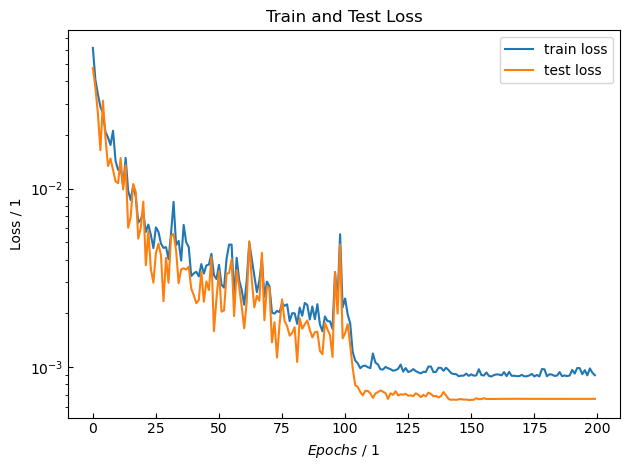

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_022.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9998087571081256 , R^2(NH3) = 0.9983620885949327
Test Dataset: R^2(H2) = 0.9997706884132728 , R^2(NH3) = 0.9988860926491425
Max Error Training: |x_H2 - x_H2,pred| = 0.02007748162959494 , |x_NH3 - x_NH3,pred| = 0.03125602044831813
Max Error Test: |x_H2 - x_H2,pred| = 0.012321216465318585 , |x_NH3 - x_NH3,pred| = 0.020253625543901366


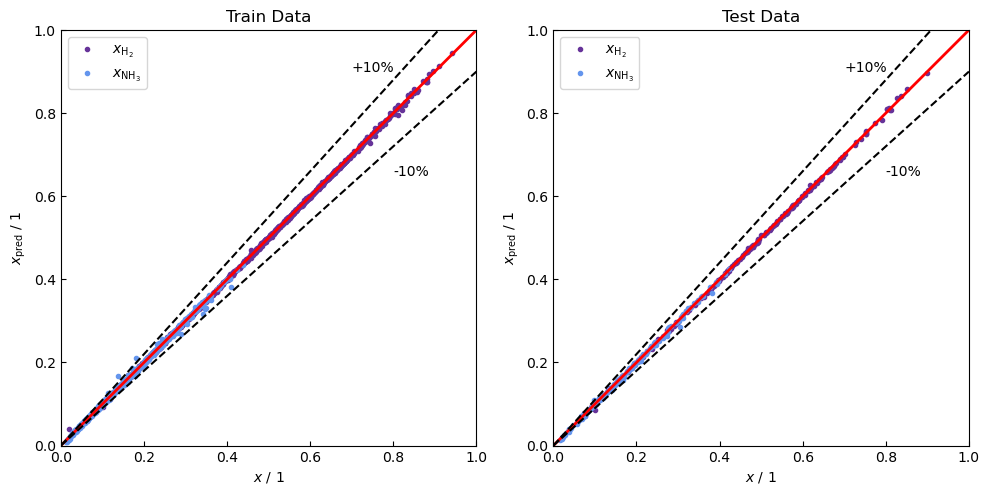

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

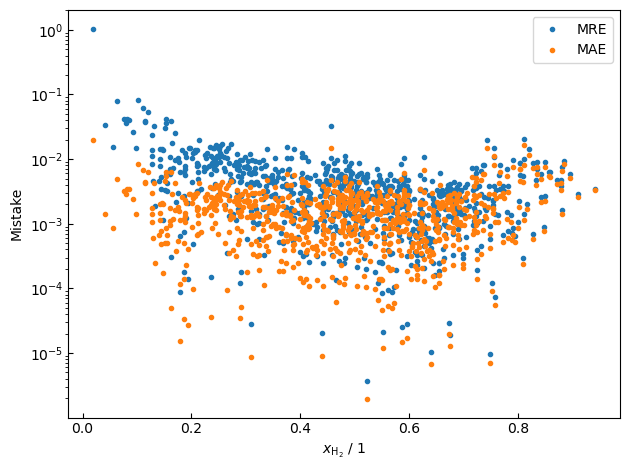

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

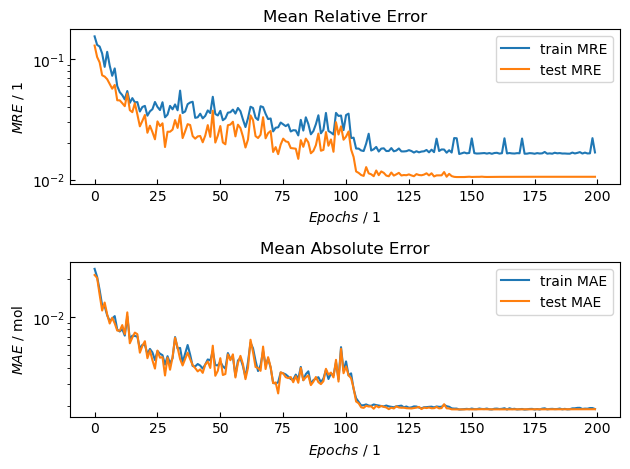

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

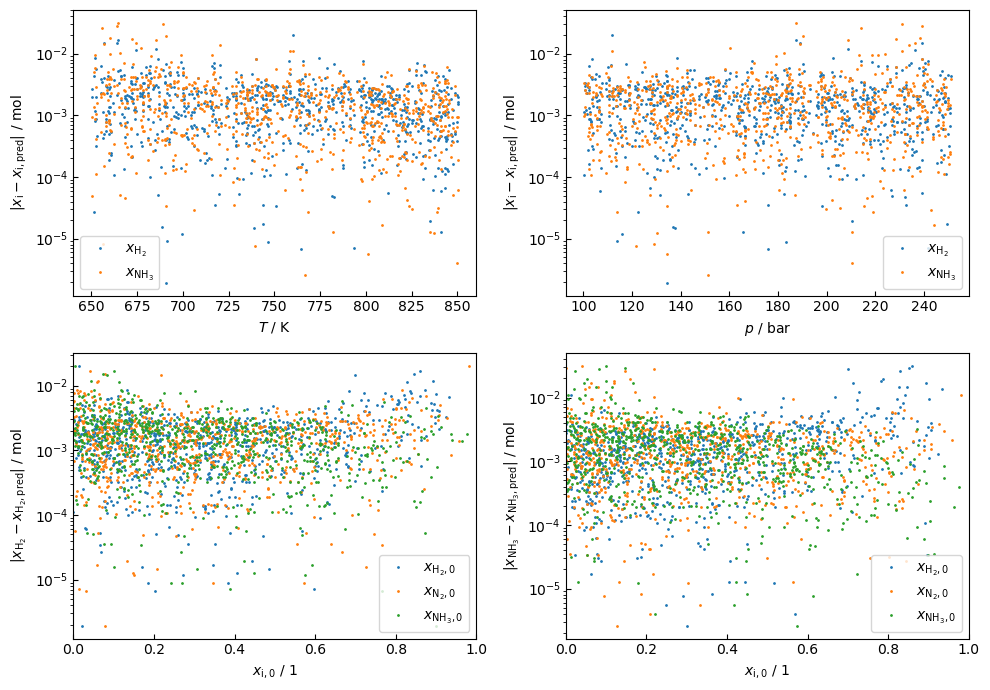

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

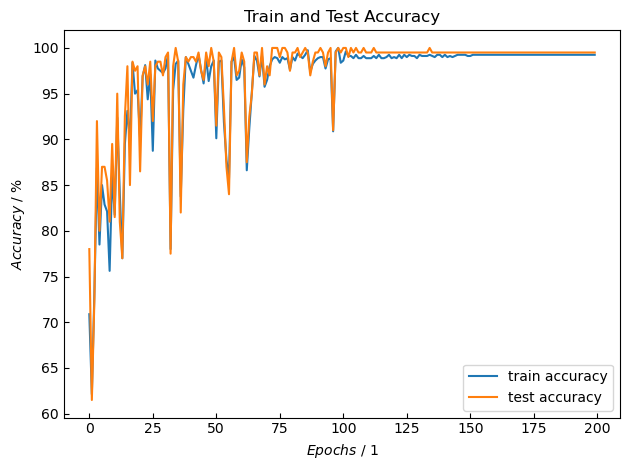

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Laufzeit Gleichgewichtsvorhersage

In [17]:
start_pred_time = time.process_time()
for X, y in train_dataloader:
            pred = net(X)
pred_time = (time.process_time() - start_pred_time)
print('Prediction time:', pred_time, 's')

Prediction time: 0.046875 s


#### Debugging Hilfe

In [18]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 2.1080e-02,  1.6799e+00, -1.4390e+00,  7.1952e-01,  6.7682e-01],
        [ 7.4725e-02,  5.5401e-01, -6.2231e-01,  2.9287e-01,  3.1139e-01],
        [ 1.0016e+00,  1.2363e+00, -6.7881e-01, -1.3856e+00,  2.0823e+00],
        [-2.1849e-01,  1.3309e-01, -1.0097e-02,  1.1138e+00, -1.1284e+00],
        [ 4.0981e-01,  1.6669e+00, -1.3793e+00,  1.9584e+00, -6.4803e-01],
        [-1.2142e+00,  3.1321e-01, -1.1855e+00,  1.9190e+00, -7.9797e-01],
        [ 1.2922e+00,  8.3739e-01,  1.2058e+00, -1.1108e+00, -4.8098e-02],
        [-1.4922e-01, -1.2948e+00, -6.1036e-01, -3.8077e-01,  9.8818e-01],
        [-1.1089e+00,  1.5590e+00, -5.5346e-01, -3.2697e-01,  8.7735e-01],
        [-1.6077e+00,  1.6608e+00, -6.6597e-01,  9.6039e-01, -3.2801e-01],
        [ 7.1847e-01,  6.7268e-01,  4.2490e-02, -1.2499e+00,  1.2358e+00],
        [-4.5049e-01, -1.5755e+00,  2.5091e-01, -1.0406e+00,  8.1732e-01],
        [ 6.4701e-02,  5.5648e-01, -1.2876e+00,  9.9257e-01,  2.4919e-01],
        [ 6.8117e-01, -9.

#### Einblick in Netzwerk

In [19]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 2.0589e-02,  2.8431e-01,  5.2862e-01, -2.1000e-01,  2.7934e-01],
         [ 2.3530e-01, -9.9984e-03,  1.0536e-02, -6.4191e-02, -8.0804e-02],
         [-5.3195e-02, -5.9308e-02,  5.9301e-02,  2.6405e-02,  4.0719e-03],
         [-3.1769e-01,  4.6757e-02,  2.1968e-01, -4.2591e-01,  2.3531e-01],
         [-4.6731e-01, -2.5928e-01,  1.0153e-01,  1.4577e-01,  4.4069e-01],
         [-1.5678e-01, -2.3697e-01, -3.1913e-02, -5.4032e-02, -8.6508e-02],
         [ 7.3761e-02,  1.0121e-01, -9.9906e-02, -1.1814e-01, -1.5768e-02],
         [ 1.1899e-02, -1.9793e-01, -1.4986e-01, -1.4963e-01, -2.5743e-01],
         [-3.2421e-01, -2.3931e-01, -1.4049e-01,  3.9298e-01, -1.0082e-01],
         [ 2.2427e-01,  7.0928e-03,  4.0315e-01,  1.9581e-01,  2.3864e-01],
         [-2.9095e-01, -3.1111e-01,  3.0526e-01,  1.7464e-01,  5.6266e-02],
         [-3.3859e-01, -5.9701e-03, -4.3355e-02, -3.8461e-02,  6.3861e-03],
         [-2.3482e-01, -1.7963e-01,  1.9983e-02, -3.5762e-05,  1.

In [20]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.6591, 0.6243, 0.4169, 0.1956, 0.8411],
        [0.3819, 0.0610, 0.7237, 0.4425, 0.9807]])
tensor([[ 0.4093, -0.0163],
        [ 0.3871,  0.0961]], grad_fn=<AddmmBackward0>)


In [21]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [22]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    #print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 7.2039e-01,  1.1810e+00,  8.9730e-01, -3.2591e-01, -5.4748e-01],
        [-1.8482e-01,  3.5686e-01, -3.9482e-04, -4.2353e-01,  4.3327e-01],
        [ 1.1900e+00,  7.0348e-01, -2.3455e-02, -1.0976e+00,  1.1448e+00],
        [-1.1193e+00, -8.0417e-01, -7.0598e-01,  1.2467e+00, -5.8139e-01],
        [ 1.3465e-01, -4.4963e-01,  1.0341e+00, -9.4375e-01, -5.0226e-02],
        [-1.0993e+00, -1.2398e+00, -1.1145e-01,  3.1370e-01, -2.1125e-01],
        [-6.2913e-01, -1.6556e+00, -1.0616e+00, -9.6326e-01,  2.0264e+00],
        [ 8.7066e-01,  1.0656e+00, -7.6539e-01, -2.6253e-01,  1.0195e+00],
        [-3.1770e-01,  9.9440e-01, -1.2310e+00,  8.1979e-01,  3.7017e-01],
        [-7.5285e-02,  1.1237e+00,  1.7720e+00, -9.2834e-01, -7.9016e-01],
        [-3.0456e-01, -3.8794e-02, -7.3988e-01,  1.7476e+00, -1.0601e+00],
        [-5.2920e-01,  7.3617e-02, -6.5247e-02, -9.8140e-01,  1.0671e+00],
        [ 9.0272e-01,  5.9305e-01, -4.0910e-01,  8.7522e-01, -4.9306e-01],
        [-1.9339e-01, -1.

#### Histogramme Verteilung von $xi$ und $x{_i}$

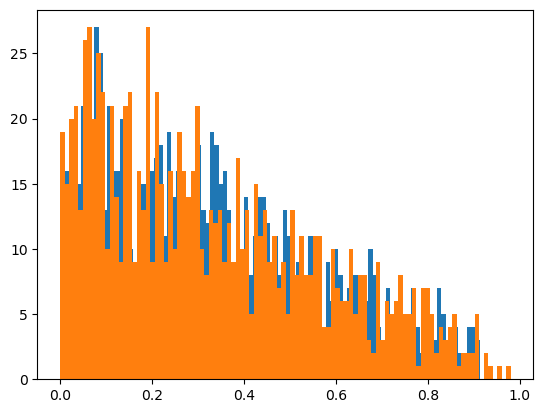

In [23]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()

#### Speichern des Modells

In [24]:
# torch.save(net.state_dict(),'data/models/ann_005_022.pth')
# np.savez('data/models/params_005_022.npz', mean_in = mean_in, std_in = std_in, mean_out = mean_out, std_out = std_out)